This notebook is for comparing sbi's joint posterior distribution to dadi Godambe uncertainty interval. 
We use the 2-epoch model of Arabidopsis in stdpopsim with fixed ancestral population size to 1e4. 
Training data is prepared by simulating 10Mb leftmost segment of Chr1.
Dadi uses normalized and polarized site-frequency-spectrum of the tree sequence, and sbi can use the same summary statistics or moments of LD statistics or even raw genotype matrix with positional information appended.
We assume uniform prior distribution between the lower and higher bound of bottleneck time and current population size, so the posterior is proportional to the likelihood function.
We measure the coverage probability at 1000 randomly sample parameter value on each of the two marginal distributions. 

In [1]:
import stdpopsim
species = stdpopsim.get_species("AraTha")
model = species.get_demographic_model("African2Epoch_1H18")

nu_true = model.populations[0].initial_size / model.model.events[0].initial_size
T_true = model.model.events[0].time / (2 * model.model.events[0].initial_size)

upper_bound = [1, 1.5]
lower_bound = [1e-2, 1e-2]


/gpfs/home/jiseonm/micromamba/envs/popgensbi_env/lib/python3.12/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
/gpfs/home/jiseonm/micromamba/envs/popgensbi_env/lib/python3.12/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [2]:
import dadi
import dadi.Godambe

In [3]:
import os
import numpy as np

In [5]:
# Run dadi Godambe with x_obs as an observed sfs if it hasn't been done yet.

if not os.path.isfile("dadi_mle.npy"):
    fs_o = np.load("../results/amortized_msprime/AraTha_2epoch_genetic_map/data/tskit_sfs/x_obs.npy")
    data = dadi.Spectrum(fs_o)
    ns = data.sample_sizes
    pts = 100
    func = dadi.Demographics1D.two_epoch
    func_ex = dadi.Numerics.make_extrap_log_func(func)


    def find_dadi_MLE(obs_sfs):
        '''
        Repeat optimization 100 times to get MLE
        Return MLE and composite-loglikelihood
        '''
        MLEs = []
        ll_list = []
        for i in range(100):
            p0 = [1,1]
            p0 = dadi.Misc.perturb_params(p0, fold=1, upper_bound=upper_bound, lower_bound=lower_bound)
            popt = dadi.Inference.optimize(p0, obs_sfs, func_ex, pts, lower_bound=lower_bound, upper_bound=upper_bound, verbose=len(p0), maxiter=3)
            MLEs.append(popt)
            model = func_ex(list(popt), ns, pts)
            ll_model = dadi.Inference.ll_multinom(model, obs_sfs)
            ll_list.append(ll_model)
        best_idx = np.argmax(ll_list)
        return MLEs[best_idx], ll_list[best_idx]


    MLE, ll = find_dadi_MLE(data)
    np.save("dadi_mle.npy", MLE)

if not os.path.isfile("godambe_cov.npy"):
    all_boot = []
    n_boot = 1000
    for i in range(n_boot):
        fs_sample = np.load(f"../results/amortized_msprime/AraTha_2epoch_genetic_map/data/tskit_sfs/default_x_{i}.npy")
        fs_sample = dadi.Spectrum(fs_sample)
        all_boot.append(fs_sample)

    # Godambe analysis to get uncertainty. Use bigger epsilon because eps=0.01 seems to give a singular cov matrix
    uncerts, GIM, H = dadi.Godambe.GIM_uncert(func_ex, (pts,), all_boot,
    list(MLE), data, log=True, multinom=False, return_GIM=True, boot_theta_adjusts=[1 for i in range(n_boot)], eps=0.05)
    cov = np.linalg.inv(GIM)
    np.save("godambe_cov.npy", cov)


In [6]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import colormaps
plt.rcParams.update({'font.size': 22})

In [7]:
npe_sfs_samples = np.load("NPE_sfs_samples.npy")
npe_momentsLD_samples = np.load("NPE_momentsLD_samples.npy")
npe_end2end_samples = np.load("NPE_end2end_samples.npy")

In [8]:
MLE = np.load("dadi_mle.npy")
cov = np.load("godambe_cov.npy")

In [9]:
import pandas as pd
import seaborn as sns

In [10]:
posterior_pd = pd.DataFrame({"nu":np.array([npe_sfs_samples[:,0], npe_momentsLD_samples[:,0], npe_end2end_samples[:,0]]).flatten(),
                            "T": np.array([npe_sfs_samples[:,1], npe_momentsLD_samples[:, 1], npe_end2end_samples[:, 1]]).flatten(),
                            "method": ["SFS + no embedding" for _ in range(len(npe_sfs_samples))]+ 
                                                ["moments of LD stats + MLP" for _ in range(len(npe_momentsLD_samples))]+
                                                ["genotype matrix + ExchangeableCNN" for _ in range(len(npe_end2end_samples))]})

invalid escape sequence '\s'invalid escape sequence '\s'invalid escape sequence '\s'

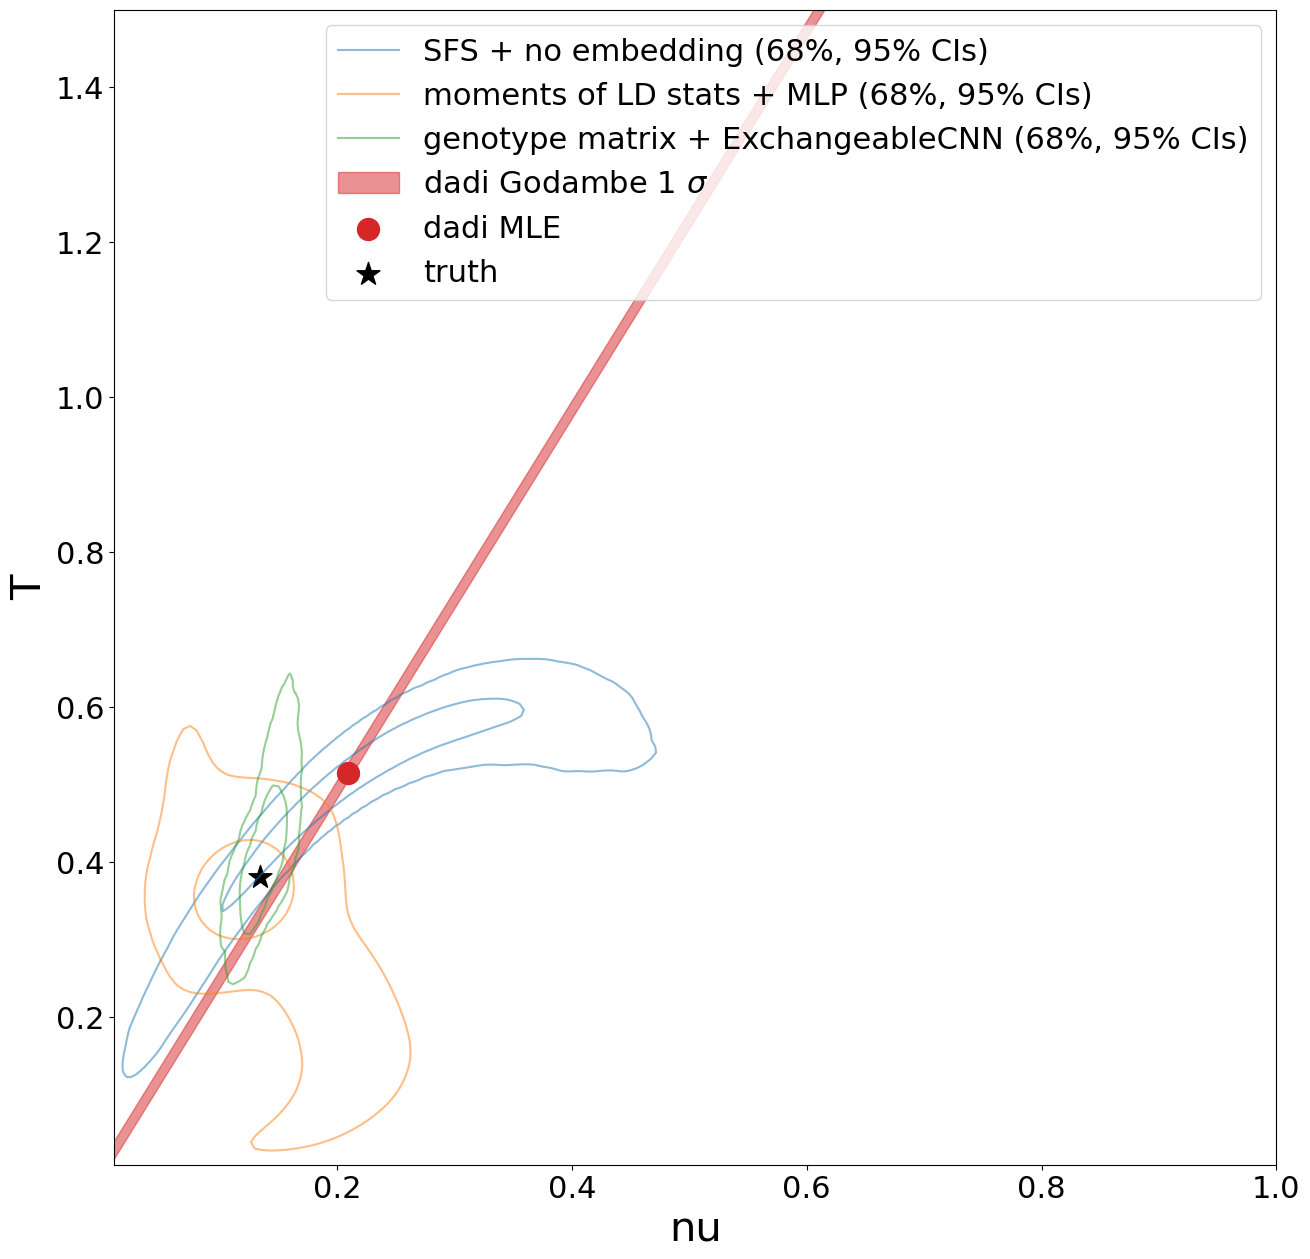

In [ ]:
vals, vecs = np.linalg.eigh(cov)
order = vals.argsort()[::-1]
vecs = vecs[:,order]
vals = vals[order]
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
width, height = 2 * np.sqrt(vals)
ellip = Ellipse(xy=MLE, width=width, height=height, angle=theta, alpha=0.5, label="dadi Godambe 1 $\sigma$", color=plt.cm.tab10(3))

fig, ax = plt.subplots(figsize=(15, 15))
kde_plot = sns.kdeplot(data=posterior_pd, x="nu", y="T", hue="method", ax=ax, legend=False, alpha=0.5, levels=[0.05, 0.32])
kde_methods = posterior_pd["method"].unique()
kde_handles = [plt.Line2D([], [], color=plt.cm.tab10(i), linestyle='-', alpha=0.5, label=f"{method} (68%, 95% CIs)") for i, method in enumerate(kde_methods)]
scatter_handles = [ax.add_artist(ellip), 
    ax.scatter(MLE[0], MLE[1], s=250, color=plt.cm.tab10(3), label="dadi MLE"),
    ax.scatter(nu_true, T_true, s=300, marker='*', color="k", label="truth")]
all_handles = kde_handles + scatter_handles
ax.legend(handles=all_handles, loc='upper right')
ax.set_xlim((lower_bound[0], upper_bound[0]))
ax.set_ylim((lower_bound[1], upper_bound[1]))
ax.set_xlabel("nu", fontsize=30)
ax.set_ylabel("T", fontsize=30)
plt.savefig("posterior_comparison.pdf")

In [11]:
npe_sfs_coverage = np.load("NPE_sfs_coverage.npy")
npe_momentsLD_coverage = np.load("NPE_momentsLD_coverage.npy")
npe_end2end_coverage = np.load("NPE_end2end_coverage.npy")
dadi_coverage = np.load("dadi_coverage.npy")
alpha_grid = np.arange(0.025, 0.5, 0.025)

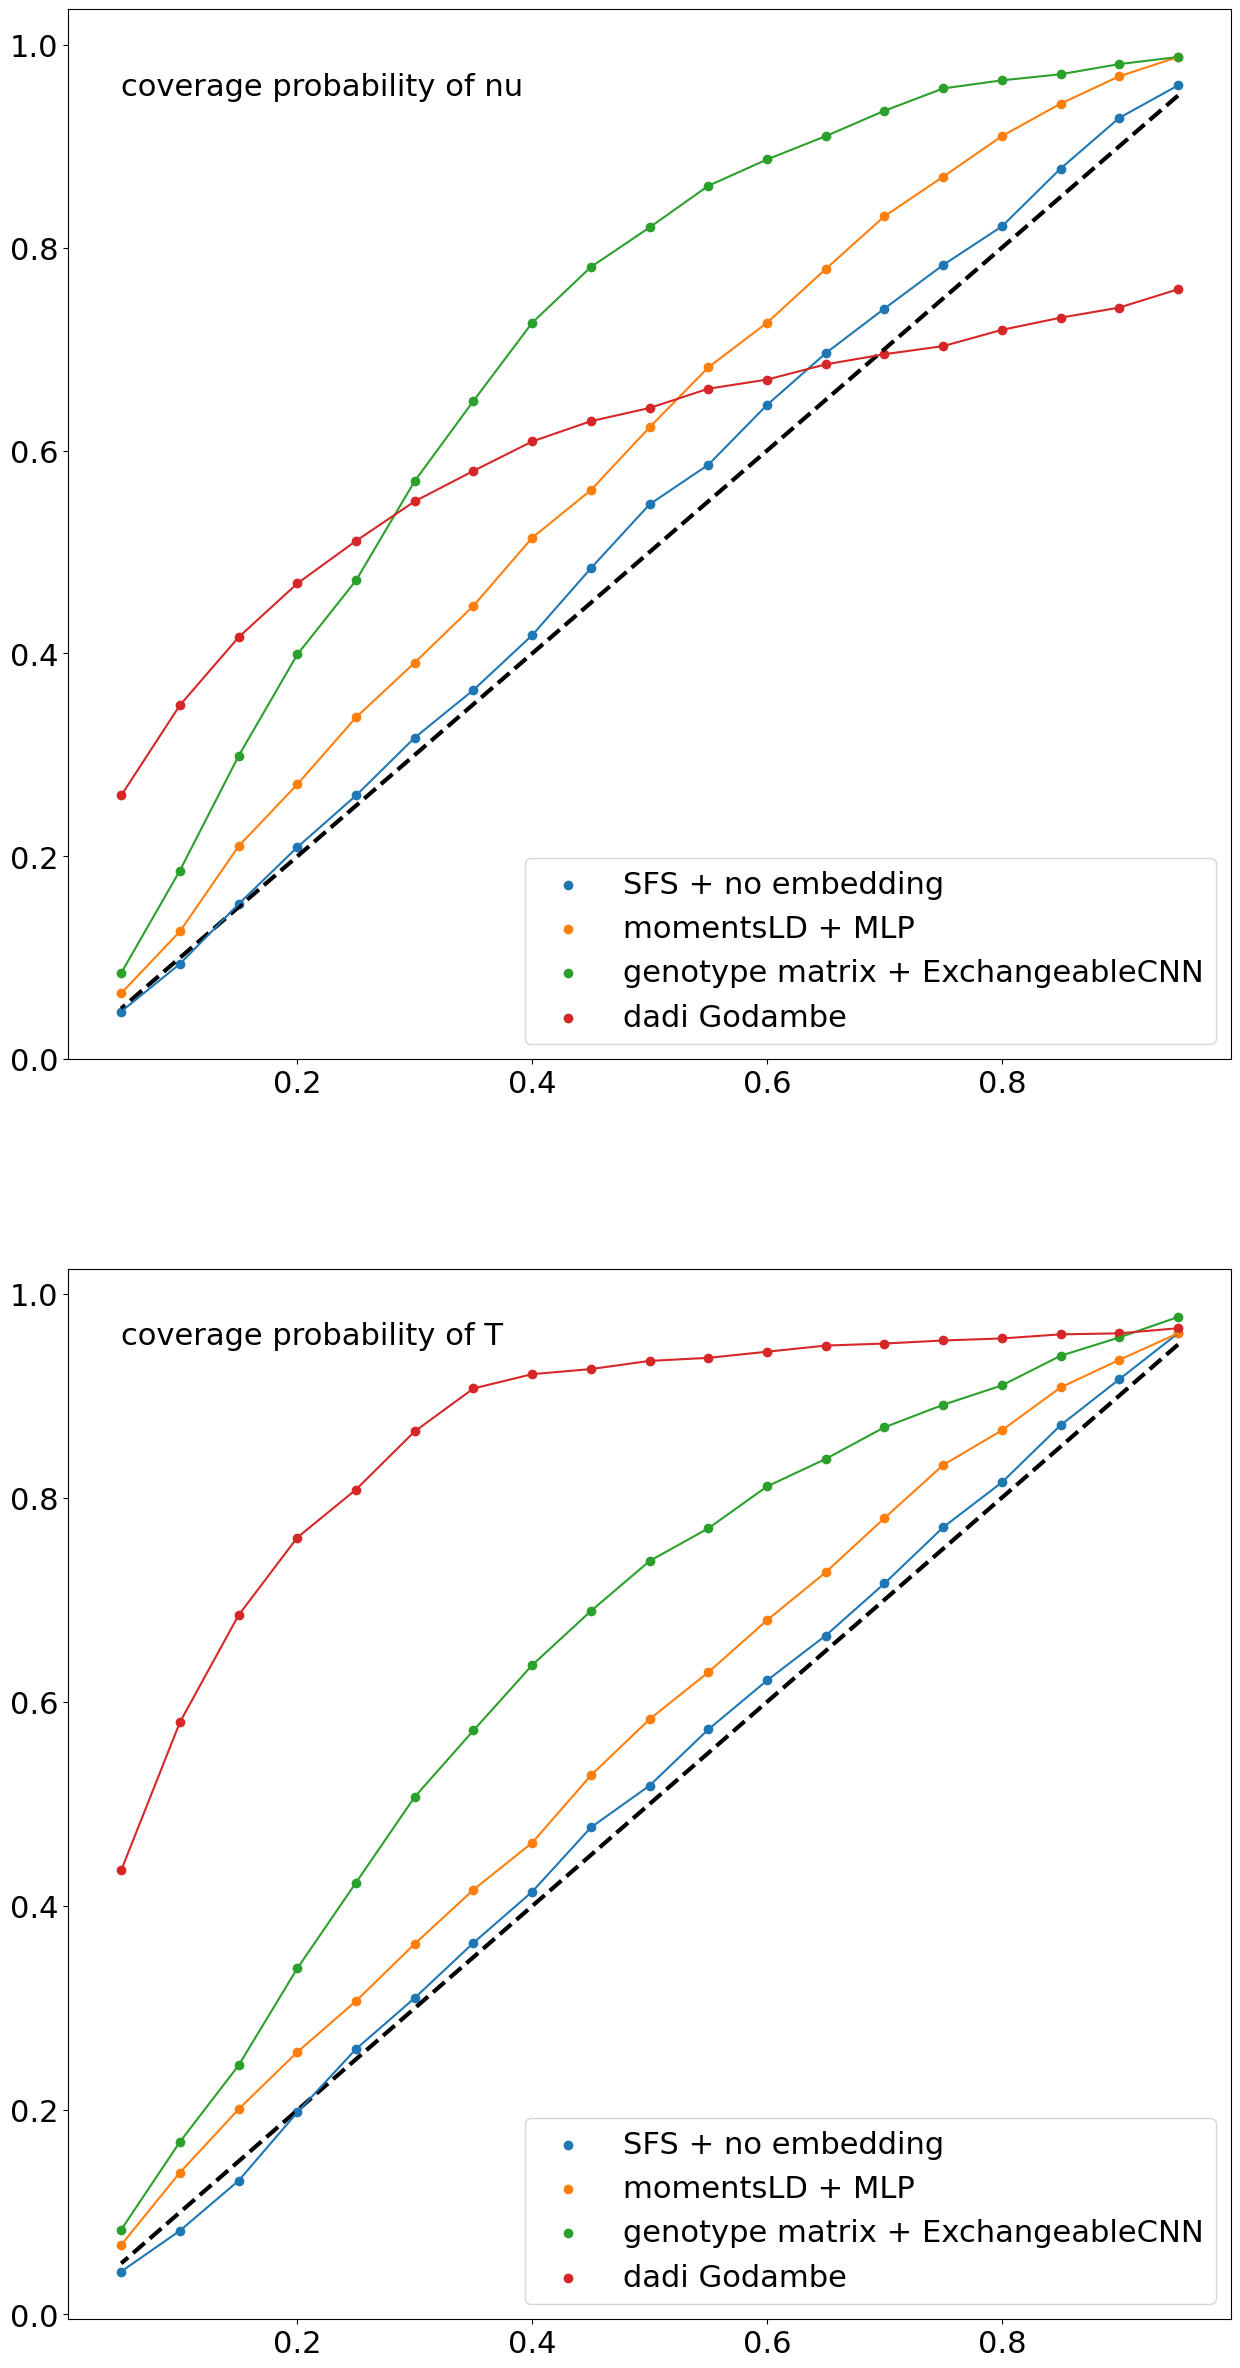

In [12]:
fig, axs= plt.subplots(2,1, figsize=(15, 30))
param_names = ["nu", "T"]
for i, name in enumerate(param_names):
    axs[i].plot(1 - 2 * alpha_grid, 1 - 2 * alpha_grid, color='k', linestyle='--', linewidth=3)
    axs[i].scatter(1 - 2 * alpha_grid, npe_sfs_coverage[i], label = 'SFS + no embedding')
    axs[i].plot(1 - 2 * alpha_grid, npe_sfs_coverage[i])

    axs[i].scatter(1 - 2 * alpha_grid, npe_momentsLD_coverage[i], label = "momentsLD + MLP")
    axs[i].plot(1 - 2 * alpha_grid, npe_momentsLD_coverage[i])

    axs[i].scatter(1 - 2 * alpha_grid, npe_end2end_coverage[i], label = "genotype matrix + ExchangeableCNN")
    axs[i].plot(1 - 2 * alpha_grid, npe_end2end_coverage[i])

    axs[i].scatter(1 - 2 * alpha_grid, dadi_coverage[i], label = "dadi Godambe")
    axs[i].plot(1 - 2 * alpha_grid, dadi_coverage[i])
    axs[i].legend()
    axs[i].text(0.05, 0.95, "coverage probability of " + name)
plt.savefig("coverage_comparison.pdf")


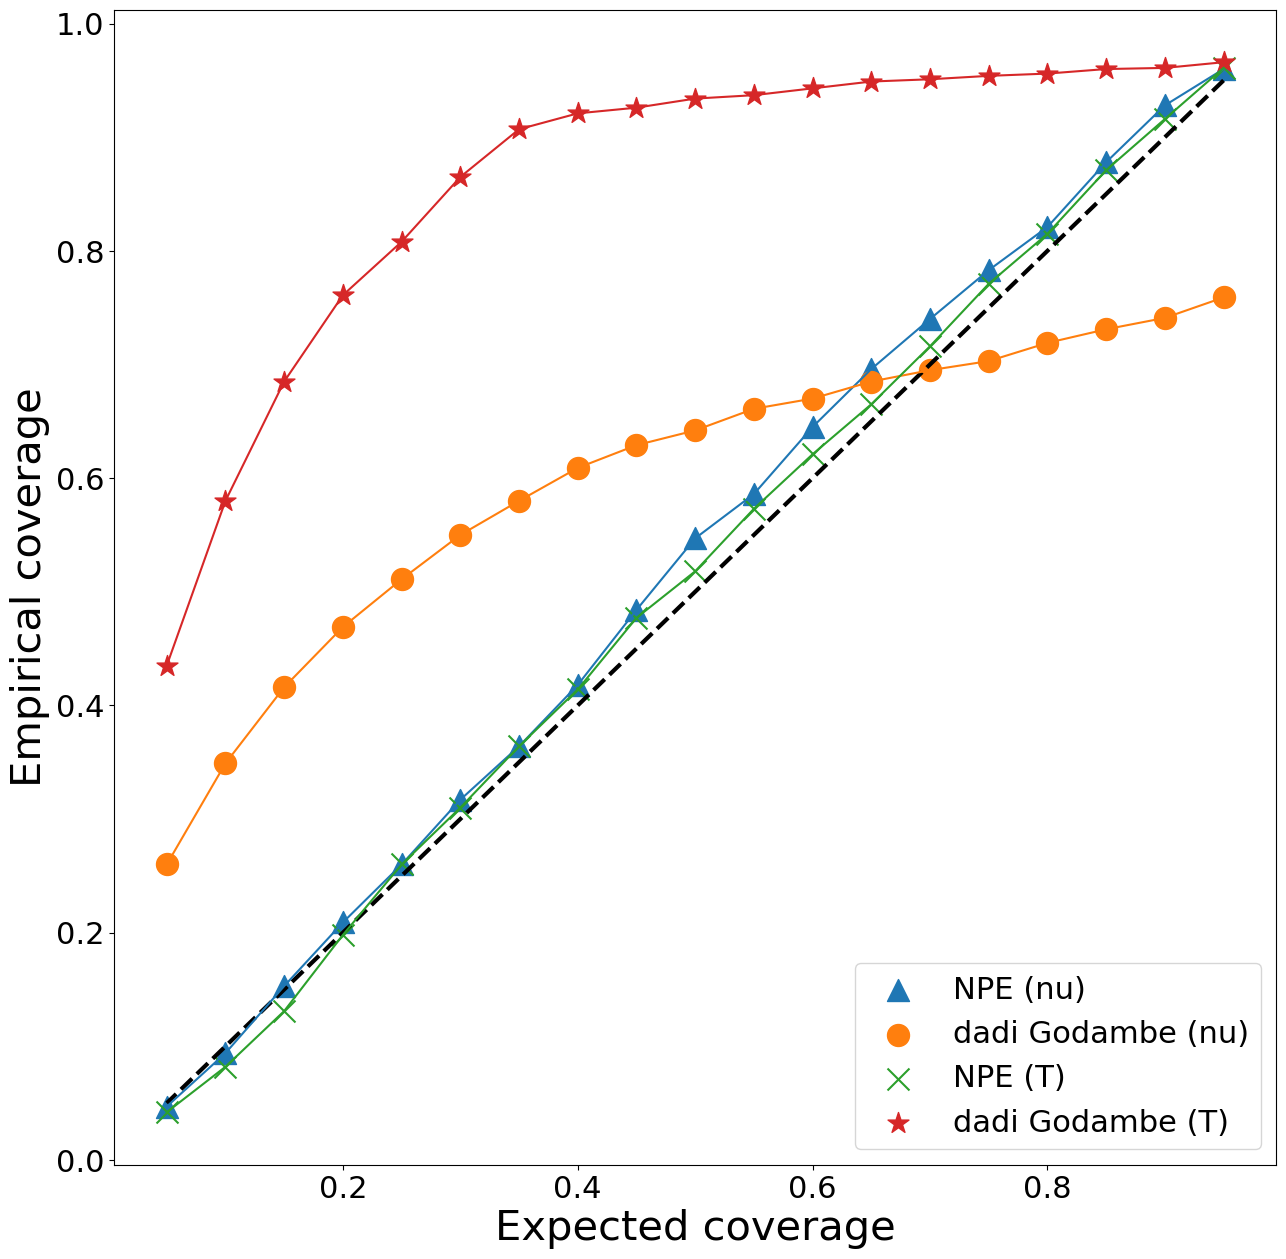

In [13]:
fig, ax= plt.subplots(figsize=(15, 15))
param_names = ["nu", "T"]
ax.plot(1 - 2 * alpha_grid, 1 - 2 * alpha_grid, color='k', linestyle='--', linewidth=3)
marker_list = ["^", "o", "x", "*"]
for i, name in enumerate(param_names):
    ax.scatter(1 - 2 * alpha_grid, npe_sfs_coverage[i], s=250, marker= marker_list[2 * i], color= plt.cm.tab10(2 * i), label = f'NPE ({name})')
    ax.plot(1 - 2 * alpha_grid, npe_sfs_coverage[i], color=plt.cm.tab10(2 * i))
    ax.scatter(1 - 2 * alpha_grid, dadi_coverage[i], s=250, marker=marker_list[2*i+1], color=plt.cm.tab10(2 * i + 1), label = f"dadi Godambe ({name})")
    ax.plot(1 - 2 * alpha_grid, dadi_coverage[i], color=plt.cm.tab10(2 * i + 1))

ax.legend()
ax.set_xlabel("Expected coverage", fontsize=30)
ax.set_ylabel("Empirical coverage", fontsize=30)
plt.savefig("coverage_comparison_SFS_only.pdf")